GRAYSCALE

Successfully loaded 15 images.


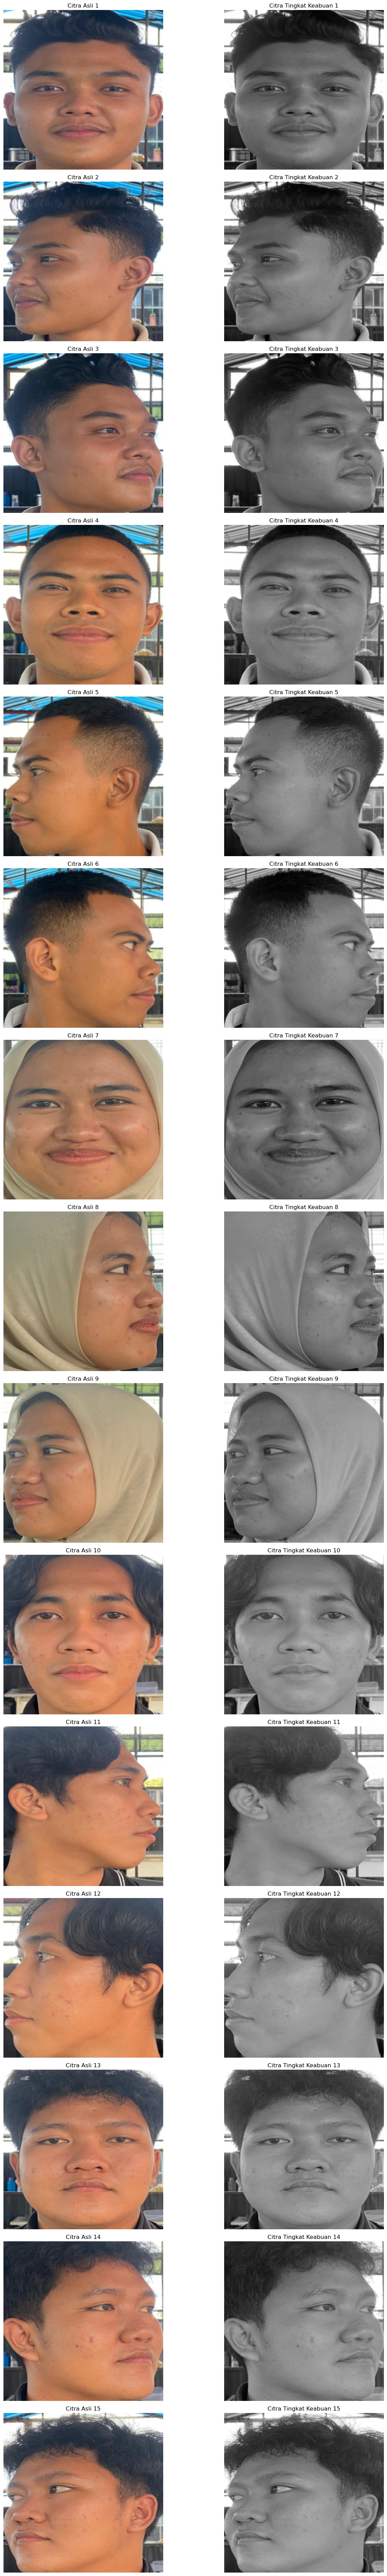

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def rgb_to_grayscale(image):
    """Konversi RGB ke tingkat keabuan."""
    width, height = image.size
    grayscale_image = Image.new("L", (width, height))

    for y in range(height):
        for x in range(width):
            # Dapatkan nilai RGB dari setiap piksel
            r, g, b = image.getpixel((x, y))

            # Hitung tingkat keabuan
            gray_value = int((r + g + b) / 3)

            # Set nilai tingkat keabuan pada piksel citra baru
            grayscale_image.putpixel((x, y), gray_value)

    return grayscale_image

def load_images_from_folder(folder_path, target_size=(256, 256), max_images=15):
    # List untuk menyimpan gambar asli dan gambar grayscale dalam bentuk array
    original_images = []
    grayscale_images = []
    filenames = []
    
    # Mendapatkan semua file gambar dari folder dan subfolder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                try:
                    image_path = os.path.join(root, file)
                    image = Image.open(image_path).resize(target_size)
                    grayscale_image = rgb_to_grayscale(image)
                    
                    original_images.append(np.array(image))
                    grayscale_images.append(np.array(grayscale_image))
                    filenames.append(file)
                    
                    # Berhenti jika sudah mencapai batas max_images
                    if len(original_images) >= max_images:
                        return original_images, grayscale_images, filenames
                except Exception as e:
                    print(f"Failed to process {file}: {e}")
    
    return original_images, grayscale_images, filenames

# Path ke folder yang berisi gambar-gambar
folder_path = 'Data2'  # Ganti dengan path yang benar

# Memuat gambar dari folder dan subfolder
original_images, grayscale_images, filenames = load_images_from_folder(folder_path)

# Memeriksa apakah ada gambar yang berhasil dimuat
if original_images and grayscale_images:
    # Mengubah list menjadi array numpy 4D
    print(f"Successfully loaded {len(original_images)} images.")
    
    # Menampilkan gambar-gambar asli dan grayscale yang telah dimuat
    fig, axes = plt.subplots(len(original_images), 2, figsize=(15, len(original_images) * 5))
    
    for i, (orig_img, gray_img) in enumerate(zip(original_images, grayscale_images)):
        # Tampilkan gambar asli
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Citra Asli {i+1}')
        axes[i, 0].axis('off')
        
        # Tampilkan gambar grayscale
        axes[i, 1].imshow(gray_img, cmap='gray')
        axes[i, 1].set_title(f'Citra Tingkat Keabuan {i+1}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No images were loaded.")


Akusisi, ekstraksi fitur, machine learning (pembagian data)

In [3]:
import numpy as np
import os
import pandas as pd
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label
import skimage
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Path ke folder yang berisi gambar-gambar
folder_path = 'Data2'  # Ganti dengan path yang benar

# Memuat gambar dari folder dan subfolder
original_images, grayscale_images, filenames = load_images_from_folder(folder_path)

# Memeriksa apakah ada gambar yang berhasil dimuat
if not original_images or not grayscale_images:
    print("No images were loaded.")
    exit()

# Akuisisi Citra
proList = ['contrast', 'dissimilarity']
featlist = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y']
properties = np.zeros(2)
glcmMatrix = []
final = []
folders = ["Jevon", "Kevin", "Lita", "Rama", "Yogi"]

# Akuisisi Citra
for folder in folders:
    print(folder)
    labell = folders.index(folder)
    INPUT_SCAN_FOLDER = "Data2/" + folder + "/"
    
    image_folder_list = os.listdir(INPUT_SCAN_FOLDER)
    
    for i in range(len(image_folder_list)):
        img = cv2.imread(INPUT_SCAN_FOLDER + image_folder_list[i])
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        
        c1 = lab[:, :, 0]
        c2 = lab[:, :, 1]
        c3 = lab[:, :, 2]
        
        # Segmentasi 
        low = np.array([30])
        up = np.array([126])

        mask = cv2.inRange(c2, low, up)

        img[mask > 0] = (255, 255, 255)
        
        # Ekstraksi Fitur
        red_channel = img[:, :, 0]
        green_channel = img[:, :, 1]
        blue_channel = img[:, :, 2]
        blue_channel[blue_channel == 255] = 0
        green_channel[green_channel == 255] = 0
        red_channel[red_channel == 255] = 0
        
        red_mean = np.mean(red_channel)
        green_mean = np.mean(green_channel)
        blue_mean = np.mean(blue_channel)
        red_std = np.std(red_channel)
        green_std = np.std(green_channel)
        blue_std = np.std(blue_channel)
        
        # Menggunakan gambar grayscale dari fungsi load_images_from_folder
        image_filename = image_folder_list[i]
        grayscale_index = filenames.index(image_filename)
        gray_image = grayscale_images[grayscale_index]

        glcmMatrix = graycomatrix(gray_image, [1], [0], levels=256, symmetric=True, normed=True)
        
        for j in range(len(proList)):
            properties[j] = graycoprops(glcmMatrix, prop=proList[j])[0, 0]
        
        features = np.array([red_std, green_std, blue_std, red_mean, green_mean, blue_mean, properties[0], properties[1], labell])
        final.append(features)

# Membuat DataFrame dari fitur-fitur yang diekstraksi
df = pd.DataFrame(final, columns=featlist)

# Memisahkan fitur dan label
X = df.drop('Y', axis=1)
y = df['Y']

# Membagi data menjadi training dan testing dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Simpan data training ke CSV
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv("Training_split.csv", index=False)

# Simpan data testing ke CSV
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv("Testing_split.csv", index=False)

print("Data training dan testing telah dibagi dan disimpan ke dalam CSV.")


Jevon
Kevin
Lita
Rama
Yogi
Data training dan testing telah dibagi dan disimpan ke dalam CSV.


In [4]:
import csv

Test = []
with open('Testing_split.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")        
        for row in csv_reader:
            Test.append(row)
labels = Test.pop(0)
print ("hasil ekstraksi dari citra ")
print(labels)
print(Test)

hasil ekstraksi dari citra 
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y']
[['45.06515950515967', '53.848734462004494', '61.47249328347075', '102.30692987480799', '126.6292045334724', '153.9077332353', '109.14036458333334', '4.368336397058823', '2.0'], ['34.713944316956706', '43.57223668427093', '71.08268321050478', '91.33206583512802', '105.4568854316224', '143.6492581957406', '106.20833333333334', '4.499264705882354', '4.0'], ['28.764923955333586', '42.015507272883646', '73.52079738134978', '91.11149678354626', '111.36566277068044', '154.50798405363776', '109.14036458333334', '4.368336397058823', '3.0'], ['42.936659182355', '46.53086442755589', '66.89381782885037', '87.95338438112765', '91.58552915530142', '118.2681455190772', '106.20833333333334', '4.499264705882354', '0.0'], ['26.84872360133413', '37.952779279244524', '65.14871503411642', '93.5227249279177', '111.88970166074809', '155.6532204903566', '106.20833333333334', '4.499264705882354', '3.0'], ['44.25071186197438', '5

In [1]:
import numpy as np
import pandas as pd
import cv2
from sklearn import svm
from sklearn.metrics import accuracy_score
from skimage.feature import graycomatrix, graycoprops
import os

# Function to load and split data
def load_data(training_data_path, testing_data_path):
    train = pd.read_csv(training_data_path)
    test = pd.read_csv(testing_data_path)
    return train, test

# Function to train the classifier
def train_classifier(train):
    columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
    X_train = train[columns]
    y_train = train['Y']
    clf = svm.SVC(kernel="rbf", C=50)
    clf.fit(X_train, y_train)
    return clf

# Function to evaluate the classifier
def evaluate_classifier(clf, test):
    columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
    X_test = test[columns]
    y_test = test['Y']
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Function to extract features from frame
def extract_features_from_frame(frame):
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    c1 = lab[:, :, 0]
    c2 = lab[:, :, 1]
    c3 = lab[:, :, 2]

    low = np.array([30])
    up = np.array([126])
    mask = cv2.inRange(c2, low, up)
    frame[mask > 0] = (255, 255, 255)

    red_channel = frame[:, :, 0]
    green_channel = frame[:, :, 1]
    blue_channel = frame[:, :, 2]
    blue_channel[blue_channel == 255] = 0
    green_channel[green_channel == 255] = 0
    red_channel[red_channel == 255] = 0

    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)
    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)

    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    glcmMatrix = graycomatrix(gray_image, [1], [0], levels=256, symmetric=True, normed=True)

    properties = []
    for prop in ['contrast', 'dissimilarity']:
        properties.append(graycoprops(glcmMatrix, prop=prop)[0, 0])

    features = [red_std, green_std, blue_std, red_mean, green_mean, blue_mean, properties[0], properties[1]]
    return features

# Function to ensure path exists
def assure_path_exists(path):
    dir = os.path.dirname(path)
    if not os.path.exists(dir):
        os.makedirs(dir)

# Load data
training_data_path = "Training_split.csv"
testing_data_path = "Testing_split.csv"
train, test = load_data(training_data_path, testing_data_path)

# Train classifier
clf = train_classifier(train)

# Evaluate classifier
evaluate_classifier(clf, test)

# List of names corresponding to labels
names = ["Yogi", "Jevon", "Lita", "Rama", "Kevin"]

# Initialize camera
cap = cv2.VideoCapture(0)

# Set camera properties
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FOCUS, 0)

# Load Haar Cascade for face detection
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.2, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x-20, y-20), (x+w+20, y+h+20), (252, 192, 203), 2)

        # Extract features from frame for SVM classification
        face_region = frame[y:y+h, x:x+w]
        features = extract_features_from_frame(face_region)

        # Output debugging for extracted features
        print("Extracted features:", features)

        # Predict using SVM classifier
        prediction = clf.predict([features])[0]

        # Output debugging for prediction
        print("Prediction:", prediction)

        # Ensure prediction is within bounds
        if int(prediction) < len(names):
            name = names[int(prediction)]
        else:
            name = "Unknown"

        # Display name on frame
        cv2.rectangle(frame, (x-22, y-90), (x+w+22, y-22), (252, 192, 203), -1)
        cv2.putText(frame, name, (x, y-40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)

    # Display frame with classification
    cv2.imshow("Classified Image", frame)

    # Exit if 'q' key is pressed
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Clean up
cap.release()
cv2.destroyAllWindows()

KeyError: "None of [Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'], dtype='object')] are in the [columns]"